# Hypothesis 3: Feedback Tone vs. Efficiency

This notebook analyzes how the tone of reviewer feedback (Positive, Negative, or Neutral) affects the efficiency of AI-generated Pull Requests (PRs). Efficiency is measured by the PR lifecycle (time to decision) and the number of iteration cycles.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np

# Set plot style
sns.set_theme(style="whitegrid")

# Ensure VADER lexicon is downloaded
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    print("Downloading VADER lexicon...")
    nltk.download('vader_lexicon')

## 1. Load Data
We load the necessary datasets from Hugging Face: `pr_df`, `pr_timeline_df`, and `pr_reviews_df`.

In [2]:
print("Loading datasets...")
try:
    all_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_pull_request.parquet")
    all_repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_repository.parquet")
    all_user_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_user.parquet")

    # Basic
    pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pull_request.parquet")
    repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/repository.parquet")
    user_df = pd.read_parquet("hf://datasets/hao-li/AIDev/user.parquet")
    
    # Comments and reviews
    pr_comments_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_comments.parquet")
    pr_reviews_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_reviews.parquet")
    pr_review_comments_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_review_comments_v2.parquet")
    
    # Commits
    pr_commits_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_commits.parquet")
    pr_commit_details_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_commit_details.parquet")
    
    # Related issues
    related_issue_df = pd.read_parquet("hf://datasets/hao-li/AIDev/related_issue.parquet")
    issue_df = pd.read_parquet("hf://datasets/hao-li/AIDev/issue.parquet")
    
    # Events
    pr_timeline_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_timeline.parquet")
    
    # Task type
    pr_task_type_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_task_type.parquet")
    
    # Human-PR
    human_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/human_pull_request.parquet")
    human_pr_task_type_df = pd.read_parquet("hf://datasets/hao-li/AIDev/human_pr_task_type.parquet")

    print("Datasets loaded successfully.")
except Exception as e:
    print(f"Error loading datasets: {e}")
    pr_df, pr_timeline_df, pr_reviews_df = None, None, None

Loading datasets...


C:\Users\preet\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Datasets loaded successfully.


## 2. Preprocess PR Data
We filter for closed PRs and calculate the lifecycle in hours.

In [3]:
if pr_df is not None:
    print("Preprocessing PR data...")
    closed_prs = pr_df[pr_df["state"] == "closed"].copy()
    closed_prs["created_at"] = pd.to_datetime(closed_prs["created_at"])
    closed_prs["closed_at"] = pd.to_datetime(closed_prs["closed_at"])
    closed_prs["lifecycle_hours"] = (closed_prs["closed_at"] - closed_prs["created_at"]).dt.total_seconds() / 3600
    pr_lifecycle = closed_prs[["id", "state", "lifecycle_hours"]]
    print(pr_lifecycle.head())

Preprocessing PR data...
            id   state  lifecycle_hours
0   3264933329  closed        76.038611
1   3265118634  closed        17.258056
2   3265640341  closed         0.100833
3   3265709660  closed         0.635556
16  3234102722  closed        35.815278


## 3. Calculate Iteration Cycles
We calculate the number of iteration cycles for each PR using the timeline data.

In [4]:
if pr_timeline_df is not None:
    print("Calculating iteration cycles...")
    pr_iterations = (
        pr_timeline_df
        .groupby("pr_id")
        .size()
        .reset_index(name="iteration_cycles")
    )
    print(pr_iterations.head())

Calculating iteration cycles...
        pr_id  iteration_cycles
0  2756921963                30
1  2757103560                22
2  2757124156                 7
3  2757125491                 7
4  2757179026                15


## 4. Analyze Sentiment
We perform sentiment analysis on review comments using VADER and aggregate the scores per PR.

In [5]:
if pr_reviews_df is not None:
    print("Analyzing sentiment...")
    # Extract relevant columns and drop missing bodies
    reviews = pr_reviews_df[["pr_id", "body"]].dropna().copy()
    
    sia = SentimentIntensityAnalyzer()
    
    def get_compound_score(text):
        return sia.polarity_scores(text)["compound"]
    
    # Calculate sentiment for each review
    print("Calculating VADER scores (this might take a moment)...")
    reviews["compound_score"] = reviews["body"].apply(get_compound_score)
    
    # Aggregate by PR (Mean score)
    print("Aggregating sentiment per PR...")
    pr_sentiment = reviews.groupby("pr_id")["compound_score"].mean().reset_index()
    
    # Classify sentiment
    def classify_sentiment(score):
        if score > 0.05:
            return "Positive"
        elif score < -0.05:
            return "Negative"
        else:
            return "Neutral"
            
    pr_sentiment["sentiment_category"] = pr_sentiment["compound_score"].apply(classify_sentiment)
    pr_sentiment.columns = ["id", "mean_compound_score", "sentiment_category"]
    
    print(pr_sentiment.head())

Analyzing sentiment...
Calculating VADER scores (this might take a moment)...
Aggregating sentiment per PR...
           id  mean_compound_score sentiment_category
0  2760115428               0.0000            Neutral
1  2766353261              -0.1779           Negative
2  2768057346               0.4926           Positive
3  2768057378               0.4199           Positive
4  2768132850              -0.5267           Negative


## 5. Merge Data
We merge the lifecycle, iteration cycles, and sentiment data into a single DataFrame for analysis.

In [6]:
if pr_df is not None and pr_timeline_df is not None and pr_reviews_df is not None:
    print("Merging data...")
    merged_df = pd.merge(
        pr_lifecycle,
        pr_iterations,
        left_on="id",
        right_on="pr_id",
        how="left"
    )
    
    final_df = pd.merge(
        merged_df,
        pr_sentiment,
        on="id",
        how="inner" # Only PRs with reviews/sentiment
    )
    print(final_df.head())

Merging data...
           id   state  lifecycle_hours       pr_id  iteration_cycles  \
0  3265709660  closed         0.635556  3265709660                11   
1  3214555104  closed        47.635833  3214555104                30   
2  3214724259  closed         0.004444  3214724259                12   
3  3214876564  closed         0.938333  3214876564                30   
4  3215868710  closed        13.475000  3215868710                30   

   mean_compound_score sentiment_category  
0             0.790600           Positive  
1             0.332200           Positive  
2             0.653100           Positive  
3             0.499460           Positive  
4             0.398367           Positive  


## 6. Analysis and Visualization
We perform descriptive statistics and visualize the impact of feedback tone on PR lifecycle and iteration cycles.

Analyzing tone impact...

Descriptive Statistics by Feedback Tone:
                   lifecycle_hours                                             \
                             count       mean         std       min       25%   
sentiment_category                                                              
Negative                     798.0  95.549170  228.400044  0.001667  0.473958   
Neutral                      915.0  81.789295  192.191752  0.001667  0.580694   
Positive                    2689.0  76.413640  172.415850  0.001389  0.604444   

                                                     iteration_cycles  \
                         50%        75%          max            count   
sentiment_category                                                      
Negative            7.961667  72.746458  1797.698611            798.0   
Neutral             8.646944  73.930000  1612.955000            915.0   
Positive            9.195833  68.576667  1682.583333           2689.0   

       

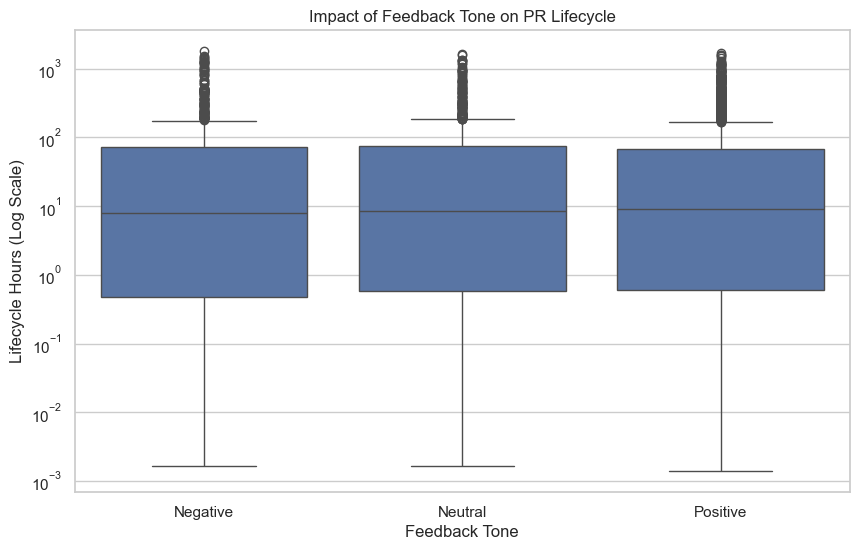

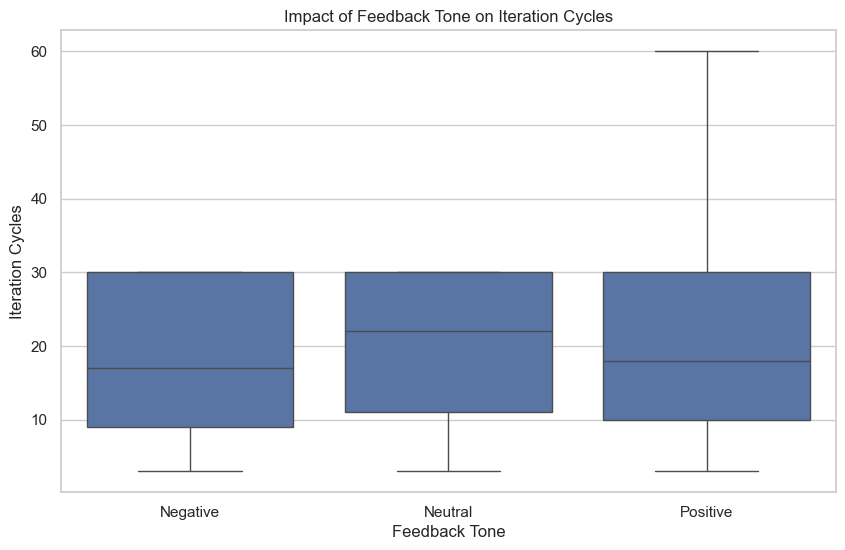

In [8]:
if 'final_df' in locals():
    print("Analyzing tone impact...")
    
    # Descriptive statistics
    stats = final_df.groupby("sentiment_category")[["lifecycle_hours", "iteration_cycles"]].describe()
    print("\nDescriptive Statistics by Feedback Tone:")
    print(stats)
    
    # Visualization: Lifecycle Hours
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="sentiment_category", y="lifecycle_hours", data=final_df, order=["Negative", "Neutral", "Positive"])
    plt.yscale("log")
    plt.ylabel("Lifecycle Hours (Log Scale)")
    plt.xlabel("Feedback Tone")
    plt.title("Impact of Feedback Tone on PR Lifecycle")
    plt.show()
    
    # Visualization: Iteration Cycles
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="sentiment_category", y="iteration_cycles", data=final_df, order=["Negative", "Neutral", "Positive"])
    plt.ylabel("Iteration Cycles")
    plt.xlabel("Feedback Tone")
    plt.title("Impact of Feedback Tone on Iteration Cycles")
    plt.savefig("boxplot_tone.png", dpi=300, bbox_inches="tight")
    plt.show()

## combining with type of agent

In [11]:
closed_prs = pr_df.loc[pr_df['state'] == 'closed', ['id',"agent"]]
closed_prs

,id,agent
0,3264933329,Claude_Code
1,3265118634,Claude_Code
2,3265640341,Claude_Code
3,3265709660,Claude_Code
16,3234102722,Claude_Code
...,...,...
33591,2857942945,Devin
33592,2857959763,Devin
33593,2858280902,Devin
33594,2858429985,Devin


In [12]:
merged_final_df = final_df.merge(
    closed_prs, 
    left_on="id", 
    right_on="id", 
    how="left"
)


merged_final_df

,id,state,lifecycle_hours,pr_id,iteration_cycles,mean_compound_score,sentiment_category,agent
0,3265709660,closed,0.635556,3265709660,11,0.790600,Positive,Claude_Code
1,3214555104,closed,47.635833,3214555104,30,0.332200,Positive,Claude_Code
2,3214724259,closed,0.004444,3214724259,12,0.653100,Positive,Claude_Code
3,3214876564,closed,0.938333,3214876564,30,0.499460,Positive,Claude_Code
4,3215868710,closed,13.475000,3215868710,30,0.398367,Positive,Claude_Code
...,...,...,...,...,...,...,...,...
4397,2977988551,closed,21.619444,2977988551,30,0.278667,Positive,Devin
4398,3275246488,closed,15.181944,3275246488,16,0.000000,Neutral,Devin
4399,3275451449,closed,2.135278,3275451449,27,-0.044050,Neutral,Devin
4400,3260325787,closed,0.711389,3260325787,7,0.954800,Positive,Devin


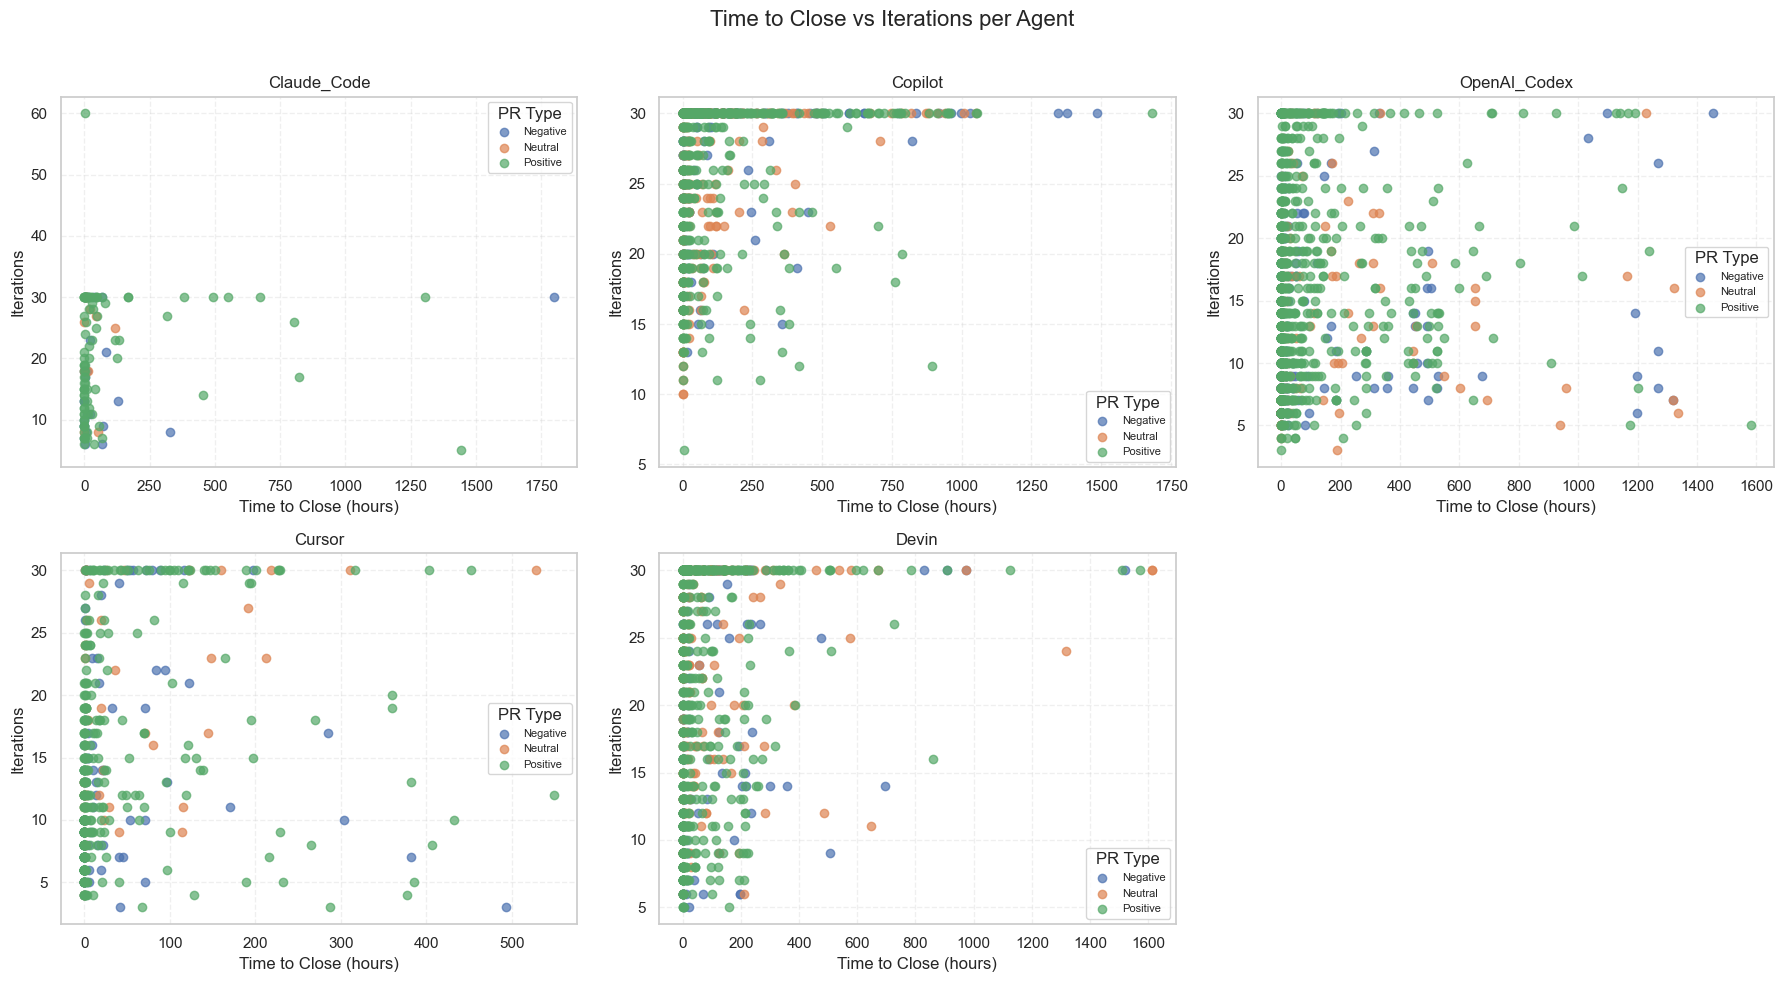

In [14]:
agents = merged_final_df["agent"].unique()
n_agents = len(agents)
cols = 3
rows = (n_agents + cols - 1) // cols  # Ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(18, 10))
axes = axes.flatten()  # Make indexing easier

for i, agent in enumerate(agents):
    ax = axes[i]
    sub = merged_final_df[merged_final_df["agent"] == agent]
    for user_type, grp in sub.groupby("sentiment_category"):
        ax.scatter(
            grp["lifecycle_hours"],
            grp["iteration_cycles"],
            alpha=0.7,
            label=user_type
        )

    ax.set_title(f"{agent}")
    ax.set_xlabel("Time to Close (hours)")
    ax.set_ylabel("Iterations")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(title="PR Type", fontsize=8)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Time to Close vs Iterations per Agent", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("sentiment_bot_agent.png", dpi=300, bbox_inches="tight")
plt.show()
